# Import Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau, LearningRateScheduler

# Data Preparation

In [2]:
TARGET_SIZE = (224, 224)
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 32
EPOCHS = 20
SELECT_DIR = 'selected_images'
CATEGORIES = [
    'apple(Organik)', 'banana(Organik)', 'battery(B3)', 'cardboard(Anorganik)', 'compost(Organik)',
    'cucumber(Organik)', 'glass(B3)', 'metal(Anorganik)', 'orange(Organik)', 'paper(Anorganik)',
    'plastic(Anorganik)', 'potato(Organik)', 'tomato(Organik)'
]


In [3]:
# Count the number of images in each category
image_counts = {category: len(os.listdir(os.path.join(SELECT_DIR, category))) for category in CATEGORIES}

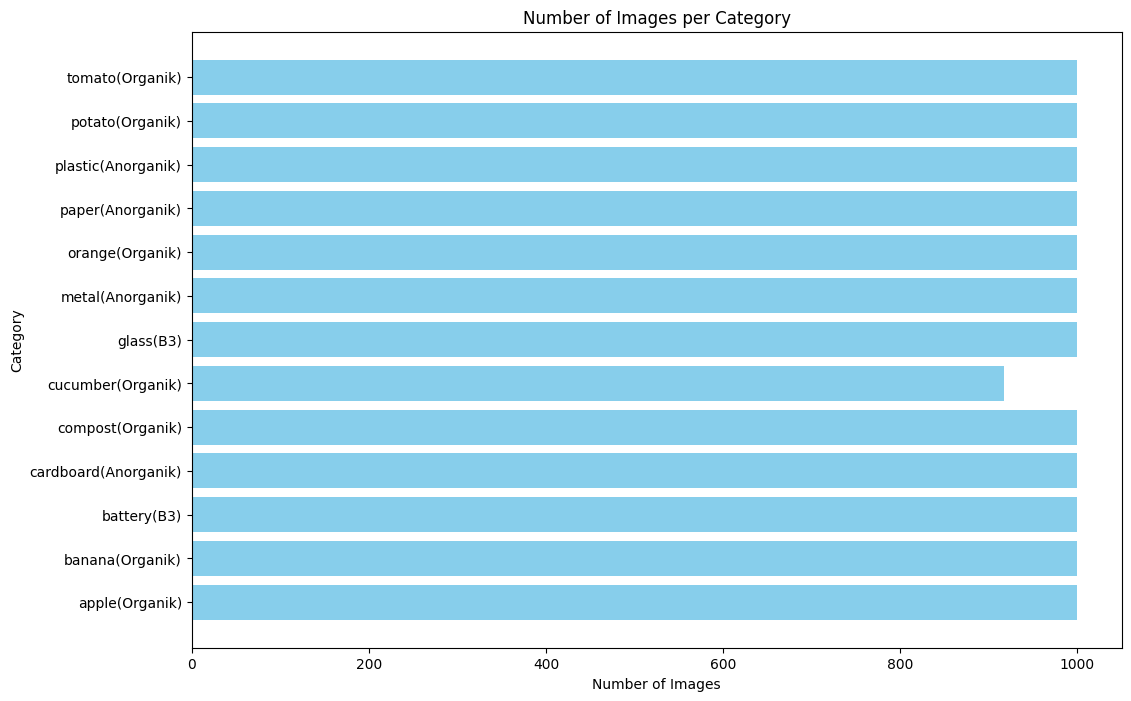

In [4]:
# Plot the image counts
plt.figure(figsize=(12, 8))
plt.barh(list(image_counts.keys()), list(image_counts.values()), color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Category')
plt.title('Number of Images per Category')
plt.show()

## Image Augmentation

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [6]:
# Prepare training and validation generators
train_generator = train_datagen.flow_from_directory(
    SELECT_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE_TRAIN,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    SELECT_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE_VAL,
    class_mode='categorical',
    subset='validation'
)

Found 10334 images belonging to 13 classes.
Found 2583 images belonging to 13 classes.


# Modeling

## Callback

In [7]:
class MyCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') >= 0.98) and (logs.get('val_accuracy') >= 0.98):
      print("\nReached 98% accuracy, stopping training")
      self.model.stop_training = True

In [8]:
def one_cycle_lr(epoch, current_lr):
    max_lr = 1e-5
    min_lr = 1e-6
    cycle_length = EPOCHS // 2
    if epoch < cycle_length:
        return min_lr + (max_lr - min_lr) * (epoch / cycle_length)
    else:
        return max_lr - (max_lr - min_lr) * ((epoch - cycle_length) / cycle_length)

lr_scheduler = LearningRateScheduler(one_cycle_lr)

def my_lr(epoch, current_lr):
    lr = 1e-8
    if epoch <= 3:
        lr *= 10**epoch
        return lr
    else:
        return 1e-4/(2**(epoch-4))

my_lr_scheduler = LearningRateScheduler(my_lr)


In [9]:
# Define callbacks
callbacks = [
    MyCallback(),
    ModelCheckpoint('model/v2/model-v2.0.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7, mode='min', verbose=1)
]

## Model

In [10]:
# Load the EfficientNetV2S model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [11]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Train

In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/20
80/80 [==============================] - ETA: 0s - loss: 0.9050 - accuracy: 0.7191
Epoch 1: val_accuracy improved from -inf to 0.69063, saving model to model/v2\model-v2.0.h5
80/80 [==============================] - 200s 2s/step - loss: 0.9050 - accuracy: 0.7191 - val_loss: 0.9510 - val_accuracy: 0.6906 - lr: 1.0000e-04
Epoch 2/20
80/80 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9150
Epoch 2: val_accuracy improved from 0.69063 to 0.71641, saving model to model/v2\model-v2.0.h5
80/80 [==============================] - 188s 2s/step - loss: 0.2586 - accuracy: 0.9150 - val_loss: 0.9174 - val_accuracy: 0.7164 - lr: 1.0000e-04
Epoch 3/20
80/80 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9479
Epoch 3: val_accuracy did not improve from 0.71641

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
80/80 [==============================] - 187s 2s/step - loss: 0.1558 - accuracy: 0.9479 - val_loss: 1.0452 -